In [52]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [53]:
df=pd.read_csv('fulldataset.csv')

In [54]:
df.shape

(1047682, 2)

In [55]:
print(df.size)
print(df.info(verbose = False))

2095364
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047682 entries, 0 to 1047681
Columns: 2 entries, URLS to Result
dtypes: object(2)
memory usage: 16.0+ MB
None


In [56]:
df.head(10)

,URLS,Result
0,http://steamcommunity.com/app/440/discussions/...,Safe
1,http://genius.com/2990078/Us-general-services-...,Safe
2,https://sports.yahoo.com/arizona-governor-slam...,Safe
3,https://www.mascus.es/,Safe
4,http://superuser.com/questions/830405/windows-...,Safe
5,https://www.instarem.com/en-au/,Safe
6,https://www.nordstromrack.com/shop/Women/Shoes,Safe
7,https://www.turkaramamotoru.com/en/united-nati...,Safe
8,https://www.span.com/,Safe
9,https://www.leicester.gov.uk/,Safe


In [57]:
import os
import pandas as pd

# specify the file path
file_path ='fulldataset.csv'

# get the size of the file in bytes
file_size_in_bytes = os.path.getsize(file_path)

# convert the size to MB
file_size_in_MB = file_size_in_bytes / (1024 * 1024)

print(f'The size of the file is: {file_size_in_MB} MB')

# read the file into a pandas DataFrame
df = pd.read_csv(file_path)

# get the size of the DataFrame in memory
df_size_in_bytes = df.memory_usage().sum()

# convert the size to MB
df_size_in_MB = df_size_in_bytes / (1024 * 1024)

print(f'The size of the DataFrame in memory is: {df_size_in_MB} MB')

The size of the file is: 72.08396625518799 MB
The size of the DataFrame in memory is: 15.98648452758789 MB


In [58]:
print(len(df.Result))

1047682


In [59]:
df=df.rename(columns={"URLS":'url','Result':'type'})

In [60]:
df.type.value_counts()

type
Safe      559308
Unsafe    488374
Name: count, dtype: int64

## Feature Engineering

In [61]:
import re

def having_ip_address(url):
    match = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.)'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/|'  # IPv4
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'  # IPv4 in hexadecimal
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # IPv6
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(re.escape(hostname), url)  # Escaping the hostname
    if match:
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))


In [62]:
df['url'].iloc[38773:38777]

38773     http://20.151.68.178/Finance/tang/questions.html
38774                          http://njolfs.hyperphp.com/
38775    http://lz5.1ee.myftpupload.com/mvc/22785dd2577...
38776        http://colibanboxes.com.au/arfrap/allo/49b19/
Name: url, dtype: object

In [63]:
from googlesearch import search

In [64]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [65]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,http://steamcommunity.com/app/440/discussions/...,Safe,0,1,1,2
1,http://genius.com/2990078/Us-general-services-...,Safe,0,1,1,1
2,https://sports.yahoo.com/arizona-governor-slam...,Safe,0,1,1,3
3,https://www.mascus.es/,Safe,0,1,1,2
4,http://superuser.com/questions/830405/windows-...,Safe,0,1,1,1


In [66]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [67]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [68]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,http://steamcommunity.com/app/440/discussions/...,Safe,0,1,1,2,0,0,10,1,...,2,2,0,0,0,110,18,0,26,66
1,http://genius.com/2990078/Us-general-services-...,Safe,0,1,1,1,0,0,3,0,...,1,0,0,11,0,121,10,1,12,91
2,https://sports.yahoo.com/arizona-governor-slam...,Safe,0,1,1,3,0,0,1,0,...,1,0,1,19,3,387,16,0,38,312
3,https://www.mascus.es/,Safe,0,1,1,2,1,0,1,0,...,1,0,0,0,0,22,13,0,0,16
4,http://superuser.com/questions/830405/windows-...,Safe,0,1,1,1,0,0,3,0,...,1,0,0,11,0,100,13,0,7,75


In [69]:
#!pip install tld

In [70]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [71]:
df = df.drop("tld",axis=1)

In [72]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [73]:
df['type'].value_counts()

type
Safe      559308
Unsafe    488374
Name: count, dtype: int64

## Target Encoding

In [78]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()



type_code
0    559308
1    488374
Name: count, dtype: int64

## Creation of Feature & Target 

In [79]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [80]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,1,2,0,0,10,1,0,0,2,...,0,0,0,110,18,0,3,3,26,66
1,0,1,1,0,0,3,0,0,0,1,...,0,11,0,121,10,1,7,3,12,91
2,0,1,3,0,0,1,0,0,1,1,...,1,19,3,387,16,0,108,3,38,312
3,0,1,2,1,0,1,0,0,1,1,...,0,0,0,22,13,0,0,2,0,16
4,0,1,1,0,0,3,0,0,0,1,...,0,11,0,100,13,0,9,3,7,75


In [81]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

## Train Test Split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# Model Building 

## 1. Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier
import time
str_time=time.time()
rf = RandomForestClassifier(n_estimators=999,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['Safe','Unsafe']))
print(time.time()-str_time)

              precision    recall  f1-score   support

        Safe       0.90      0.88      0.89    111862
      Unsafe       0.86      0.89      0.88     97675

    accuracy                           0.88    209537
   macro avg       0.88      0.88      0.88    209537
weighted avg       0.88      0.88      0.88    209537

1550.2382221221924


In [89]:
import sklearn.metrics as metrics

In [90]:
score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

accuracy:   0.882


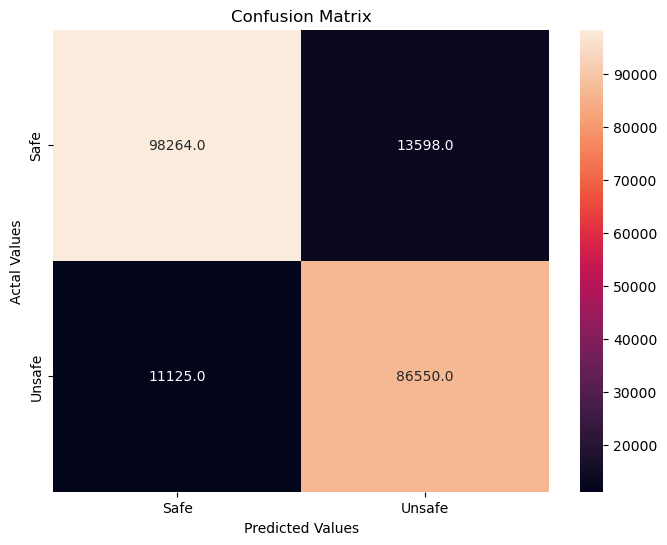

In [91]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['Safe','Unsafe'], 
                     columns = ['Safe','Unsafe'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [92]:
lgb = LGBMClassifier(objective='binary', boosting_type='gbdt',n_estimators=999, n_jobs=5, silent=True, random_state=5)

LGB_C = lgb.fit(X_train, y_train)

y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test, y_pred_lgb, target_names=['Safe', 'Unsafe']))

score = accuracy_score(y_test, y_pred_lgb)
print(f"Accuracy: {score:.3f}")

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 390699, number of negative: 447446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 838145, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466147 -> initscore=-0.135618
[LightGBM] [Info] Start training from score -0.135618
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

        Safe       0.95      0.83      0.89    111862
      Unsafe       0.83      0.95      0.89     97675

    accuracy                           0.89    209537
   macro avg       0.89      0.89      0.89    209537
weighted avg       0.89   

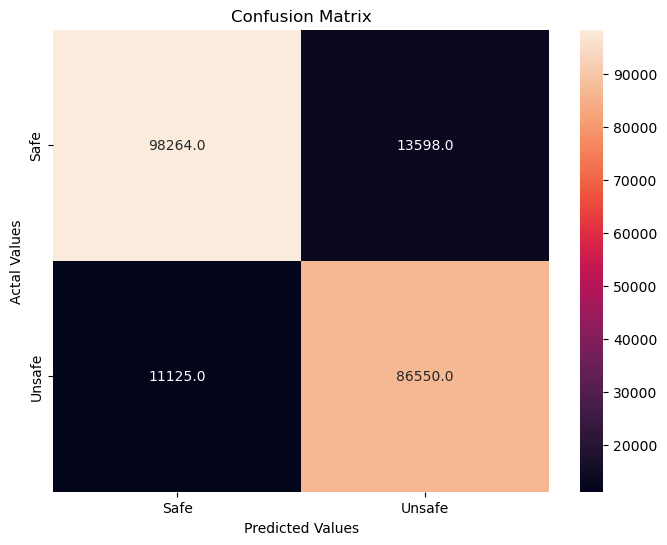

In [93]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['Safe','Unsafe'], 
                     columns = ['Safe','Unsafe'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## 3. XGboost Classifier

In [94]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['Safe','Unsafe']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

        Safe       0.94      0.83      0.88    111862
      Unsafe       0.83      0.94      0.88     97675

    accuracy                           0.88    209537
   macro avg       0.88      0.88      0.88    209537
weighted avg       0.89      0.88      0.88    209537

accuracy:   0.880


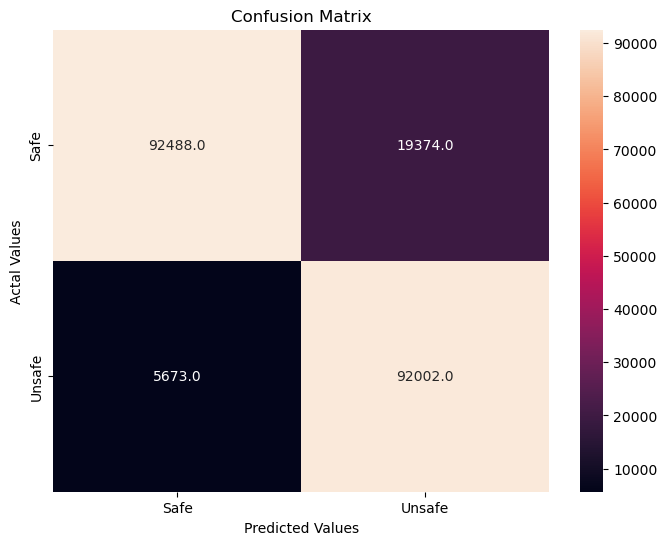

In [95]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,index = ['Safe','Unsafe'], columns = ['Safe','Unsafe'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Prediction

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [97]:
def main(url):
    
    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status

In [103]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))
    
    print(features_test)
    pred = lgb.predict(features_test)
    print(pred)
    print(int(pred[0]))
    if int(pred[0]) == 0:
        res="SAFE"
        return res
    elif int(pred[0])==1:
        res="UNSafe"
        return res
urls =['https://www.coffer.com']
for url in urls:
     print(get_prediction_from_url(url))

[[ 0  1  2  1  0  0  0  0  1  1  0  0  0  0 22 14  0  0 17  0  3]]
[LightGBM] [Warning] Unknown parameter: silent
[1]
1
UNSafe
